# SI 370 - 9.2: Clustering II
## Objectives:
- Be able to perform k-means clustering
- Be able to execute various techniques for picking k
- Evaluate cluster quality

In [2]:
import numpy as np
import scipy as sp
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
import sklearn as sk
import sklearn.metrics as skm
import sklearn.cluster as skc
import sklearn.decomposition as skd
import sklearn.mixture as skmix
import sklearn.manifold as manifold
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)

# make the Pandas tables a little more readable
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
# Filter all warnings.
# A recent matplotlib update around October 2015 causes various 
# spurious warnings.
import warnings
warnings.filterwarnings('ignore')

In [4]:
# recreate our traits dataset from last time

traits = [
    ('Alice', ['Accessible', 'Confident', 'Creative', 'Sweet']),
    ('Bob', ['Strong', 'Confident', 'Creative','Tidy']),
    ('Charlie', ['Confident', 'Strong', 'Accessible', 'Sweet']),
    ('Dacy', ['Accessible', 'Strong', 'Tidy', 'Confident']),
    ('Emily', ['Reserved', 'Cute', 'Quiet', 'Impassive']),
    ('Fred', ['Cute', 'Impassive', 'Gentle','Confident']),
    ('George', ['Cute', 'Quiet', 'Reserved', 'Confident'])
]

# first, let's grab the names for everyone 
names = [x[0] for x in traits]
df_traits = pd.DataFrame(index=names)

# this is the optimized version, btw
# notice that we incorporated two loops into one
# and check for the (non)existence of the column before adding it
for t in traits:
    person = t[0]  # person's name
    ptraits = t[1]  # this person's specific traits
    for pt in ptraits:
        if not pt in df_traits.columns:
            # haven't seen this trait before, create column
            df_traits[pt] = 0
        df_traits.set_value(person,pt,1)  # row,column,value

df_traits

Accessible  Confident  Creative  Sweet  Strong  Tidy  Reserved  Cute  \
Alice             1          1         1      1       0     0         0     0   
Bob               0          1         1      0       1     1         0     0   
Charlie           1          1         0      1       1     0         0     0   
Dacy              1          1         0      0       1     1         0     0   
Emily             0          0         0      0       0     0         1     1   
Fred              0          1         0      0       0     0         0     1   
George            0          1         0      0       0     0         1     1   

         Quiet  Impassive  Gentle  
Alice        0          0       0  
Bob          0          0       0  
Charlie      0          0       0  
Dacy         0          0       0  
Emily        1          1       0  
Fred         0          1       1  
George       1          0       0

In [5]:
# let's also create our 12 point dataset
# set the seed to 0 so we all get the same thing
np.random.seed(0)

# Let's create a DataFrame.
df_xy = pd.DataFrame({'x': np.random.randn(12) * 0.2 + np.repeat(np.arange(3)+1, 4), 
                      'y': np.random.randn(12) * 0.2 + np.repeat(np.array([1,2,1]), 4)})

df_xy

x         y
0   1.352810  1.152208
1   1.080031  1.024335
2   1.195748  1.088773
3   1.448179  1.066735
4   2.373512  2.298816
5   1.804544  1.958968
6   2.190018  2.062614
7   1.969729  1.829181
8   2.979356  0.489402
9   3.082120  1.130724
10  3.028809  1.172887
11  3.290855  0.851567

# 1. K-means

Let's first revisit the 12-point toy dataset

In [6]:
# make a copy
df_xy_wl = df_xy.copy()

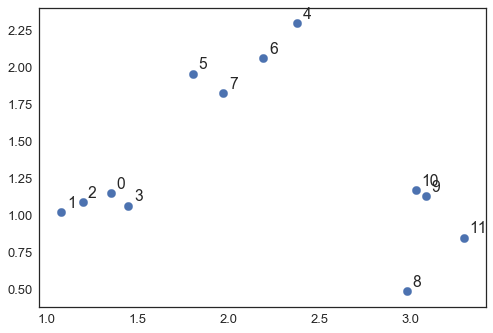

In [7]:
# plot the data
plt.scatter(df_xy_wl.x, df_xy_wl.y, s=70)
for i, xi in enumerate(df_xy_wl.x):
    plt.annotate(str(i),(xi+0.03, df_xy_wl.y[i] + 0.03))

In [8]:
# Perform k-means using the scikit-learn package
kmeans_model = skc.KMeans(n_clusters=2)
kmeans_model.fit(df_xy_wl)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [9]:
df_xy_wl

x         y
0   1.352810  1.152208
1   1.080031  1.024335
2   1.195748  1.088773
3   1.448179  1.066735
4   2.373512  2.298816
5   1.804544  1.958968
6   2.190018  2.062614
7   1.969729  1.829181
8   2.979356  0.489402
9   3.082120  1.130724
10  3.028809  1.172887
11  3.290855  0.851567

In [10]:
# grab the labels
kmeans_model.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1], dtype=int32)

In [37]:
# augment the table with labels
df_xy_wl['cluster_labels_kmeans'] = kmeans_model.labels_
#df_xy_wl

In [38]:
# these are the centers of the (3) clusters 
centroids = kmeans_model.cluster_centers_
centroids

array([[ 1.6768213 ,  1.56020358,  0.5       ],
       [ 3.09528484,  0.911145  ,  2.        ]])

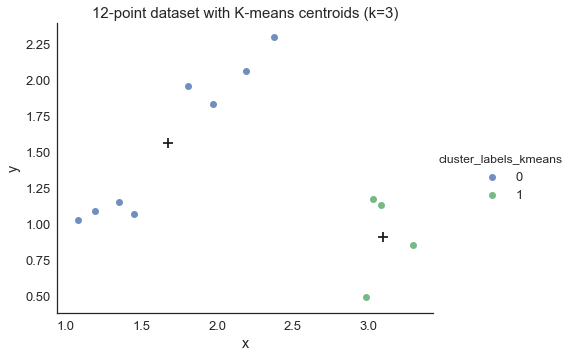

In [39]:
# Plot the clusters with their centroids.
f = sns.lmplot(x='x', y='y', data=df_xy_wl, hue='cluster_labels_kmeans',
               fit_reg=False, size=5, aspect=1.3)
f.ax.scatter(centroids[:,0], centroids[:,1], marker='+', s=100,
             linewidths=2, color='k');
plt.title('12-point dataset with K-means centroids (k=3)', fontsize=15)

### Exercise:

- Step 1: Perform k-means on the iris dataset. Use petal_length and petal_width only. Obtain the cluster labels. Set k=3.
- Step 2: Create a new scatterplot using the k-means cluster labels as hue. Compare it with the original scatterplot. 
- Step 3: Create a confusion matrix. Compare it with the one for hierarchical clustering.

In [24]:
# Exercise start
df_iris = sns.load_dataset('iris')
df_iris_plpw = df_iris[['petal_length', 'petal_width']]

In [25]:
# create a k-means model, k=3, and fit the data
kmeans_model = skc.KMeans(n_clusters=3).fit(df_iris_plpw)
# find the centroids
centroids = kmeans_model.cluster_centers_
# find the "labels"
cluster_labels = kmeans_model.labels_
# count how many of each we have
pd.value_counts(cluster_labels)

2    52
1    50
0    48
dtype: int64

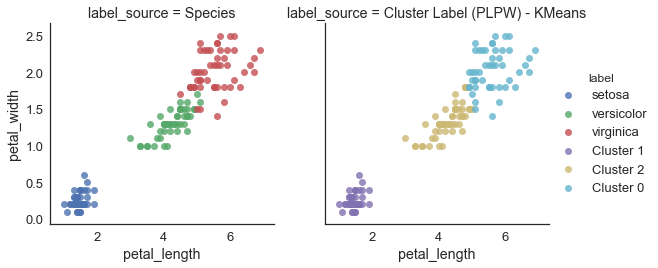

In [26]:
# Step 5: Scatterplot comparison: true label vs. cluster label
df_a = df_iris.copy()
df_b = df_iris.copy()
df_a['label_source'] = 'Species'
df_b['label_source'] = 'Cluster Label (PLPW) - KMeans'
df_a['label'] = df_a['species']
df_b['label'] = ['Cluster %d'%x for x in cluster_labels]
df_c = pd.concat((df_a, df_b), axis=0, ignore_index=True)
sns.lmplot(x='petal_length', y='petal_width', col='label_source',
           hue='label', data=df_c, fit_reg=False, size=4);

In [26]:
df_iris['cluster_label_plpw_kmeans'] = cluster_labels
df_iris.pivot_table(index='species', columns='cluster_label_plpw_kmeans', 
                    aggfunc='size', fill_value=0)

cluster_label_plpw_kmeans   0   1   2
species                              
setosa                     50   0   0
versicolor                  0   2  48
virginica                   0  46   4

# 2. Higher Dimensional K-means

Sometimes (often) we have more than two features.  We can use dimensionality reduction (MDS/PCA) to draw the points in 2D.

In [30]:
# make a copy of the traits dataset
df_traits_mds = df_traits.copy()

In [34]:
# MDS
# want an x and y, so n_components = 2
coords = manifold.MDS(n_components=2).fit_transform(df_traits_mds)
x = [d[0] for d in coords]
y = [d[1] for d in coords]

In [37]:
# K-means
kmeans_model = skc.KMeans(2).fit(df_traits_mds)
df_traits_mds['x'] = x
df_traits_mds['y'] = y
df_traits_mds

Accessible  Confident  Creative  Sweet  Strong  Tidy  Reserved  Cute  \
Alice             1          1         1      1       0     0         0     0   
Bob               0          1         1      0       1     1         0     0   
Charlie           1          1         0      1       1     0         0     0   
Dacy              1          1         0      0       1     1         0     0   
Emily             0          0         0      0       0     0         1     1   
Fred              0          1         0      0       0     0         0     1   
George            0          1         0      0       0     0         1     1   

         Quiet  Impassive  Gentle         x         y  
Alice        0          0       0  0.513148 -1.377614  
Bob          0          0       0 -1.440491  0.132132  
Charlie      0          0       0 -0.311527 -1.196033  
Dacy         0          0       0 -1.138740 -0.704256  
Emily        1          1       0  0.923617  1.603244  
Fred         0          1       1  1.466867  0.191771  
George       1          0       0 -0.012875  1.350756

In [38]:
# fix the DataFrame
df_traits_mds['cluster_label'] = kmeans_model.labels_
df_traits_mds

Accessible  Confident  Creative  Sweet  Strong  Tidy  Reserved  Cute  \
Alice             1          1         1      1       0     0         0     0   
Bob               0          1         1      0       1     1         0     0   
Charlie           1          1         0      1       1     0         0     0   
Dacy              1          1         0      0       1     1         0     0   
Emily             0          0         0      0       0     0         1     1   
Fred              0          1         0      0       0     0         0     1   
George            0          1         0      0       0     0         1     1   

         Quiet  Impassive  Gentle         x         y  cluster_label  
Alice        0          0       0  0.513148 -1.377614              0  
Bob          0          0       0 -1.440491  0.132132              0  
Charlie      0          0       0 -0.311527 -1.196033              0  
Dacy         0          0       0 -1.138740 -0.704256              0  
Emily        1          1       0  0.923617  1.603244              1  
Fred         0          1       1  1.466867  0.191771              1  
George       1          0       0 -0.012875  1.350756              1

In [42]:
# we want the x/y of the centroids in the transformed MDS space
centroids_mds = df_traits_mds.groupby("cluster_label").mean()[['x',
                                                               'y']].as_matrix()

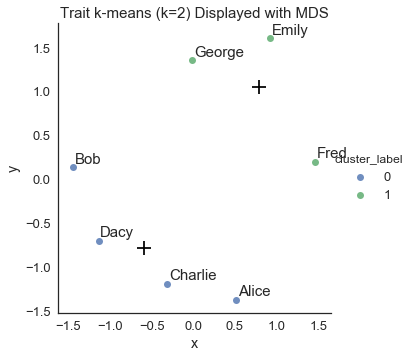

In [43]:
# Plot the result
f = sns.lmplot(x='x', y='y', data=df_traits_mds, 
               hue='cluster_label',
               fit_reg=False)
f.ax.scatter(centroids_mds[:,0], 
             centroids_mds[:,1], 
             marker='+', s=200,
             linewidths=2, color='black');
plt.title('Trait k-means (k=2) Displayed with MDS', 
          fontsize=15);
# Annotate each individual person's name
for i, name in enumerate(names):
    plt.annotate(name, (x[i]+0.02, y[i]+0.05), 
                 fontsize=15)

# 3. Picking K - How many clusters?

A number of clustering methods, such as k-means, assumes the parameter _k_ (#clusters) is known in advance, which is often not the case in practice. A number of techniques exist for determining the number of clusters in a dataset. See [this Wikipedia page](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#Information_Criterion_Approach) for a detailed discussion.

In this section, we focus on four of the approaches:
0. Use your eyeballs
1. Rule of thumb
2. The Elbow Method
3. The Silhouette Approach

For this section, let us use `df_xy`, the dataset we created in Section 1. Obviously, there are 3 natural clusters in the dataset. Let us see if all the methods listed above will be able to recover the true number of clusters.

### 3.1 See the data
Visualize the data in 2d (use MDS or PCA if necessary), see if the number of clusters is obvious

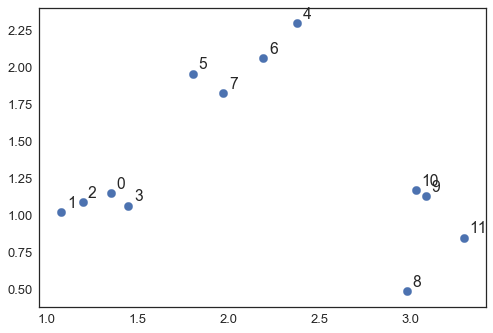

In [44]:
plt.scatter(df_xy.x, df_xy.y, s=70)
for i, xi in enumerate(df_xy.x):
    plt.annotate(str(i), (xi+0.03, df_xy.y[i]+0.03))

## 3.1 Rule of thumb:
Choosing the number of clusters to simply be

$$
k \approx \sqrt{n/2}
$$

where $n$ is the number of observations.

In [45]:
# To determine the natural cluster
np.sqrt(len(df_xy)/2)

2.4494897427831779

In [46]:
# Round this number to an integer
np.round(np.sqrt(len(df_xy)/2))

2.0

In [47]:
# what do we get? 2, but maybe expected 3
# useful advice: go up or down 1 or 2 in each direction

## 3.2 The Elbow Method
See [here](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_Elbow_Method) for an explanation.

Implementation Reference: https://github.com/nborwankar/LearnDataScience

In [49]:
# we need to generate a different k-means for every k
X = df_xy.copy()  # Using the the dataset of Section 1
K = range(1,11)  # Apply kmeans 1 to 10

range(1, 11)

In [53]:
# create one model for each k
kmeans_models = [skc.KMeans(k).fit(X) for k in K]

# find the centroids for each model
centroids = [m.cluster_centers_ for m in kmeans_models]

# calculate the distance of every point
D_k = [spd.cdist(X,cent,'euclidean') for cent in centroids]

# find the min distance
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]

# calculate sum of squares
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

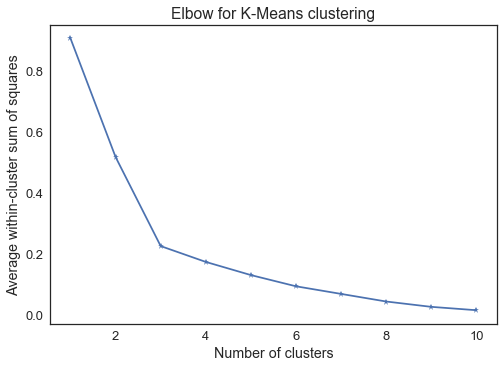

In [54]:
# plot elbow curve
plt.plot(K, avgWithinSS, 'b*-')
plt.xlabel('Number of clusters');
plt.ylabel('Average within-cluster sum of squares');
plt.title('Elbow for K-Means clustering');

According to the graph above, the "within-cluster sum of squares" (i.e., within-cluster variance) reduces as the number of clusters (k) grows. However, as k grows larger, the marginal reduction drops. At some point, this drop is so obvious that it forms a visible "angle" in the graph. The number of clusters is then chosen at this point, hence the "elbow" criterion". The "elbow" is not always easily identifiable.

In the above plot, we can manually identify k=3 as the "elbow" point.

## 6.4 The Silhouette Approach
As introduced in Section 5, the silhouette coefficient can be used for evaluating clustering where there lacks ground truth. We can use the same metric for the purpose of finding the best k for the dataset.

In [55]:
# adapted from here: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# takes as input the frame, and a list of cluster sizes to try
def plotSilhouette(X,range_n_clusters=[2, 3, 4, 5, 6]):
    X = X.as_matrix()

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()


For n_clusters = 2 The average silhouette_score is : 0.572683212677


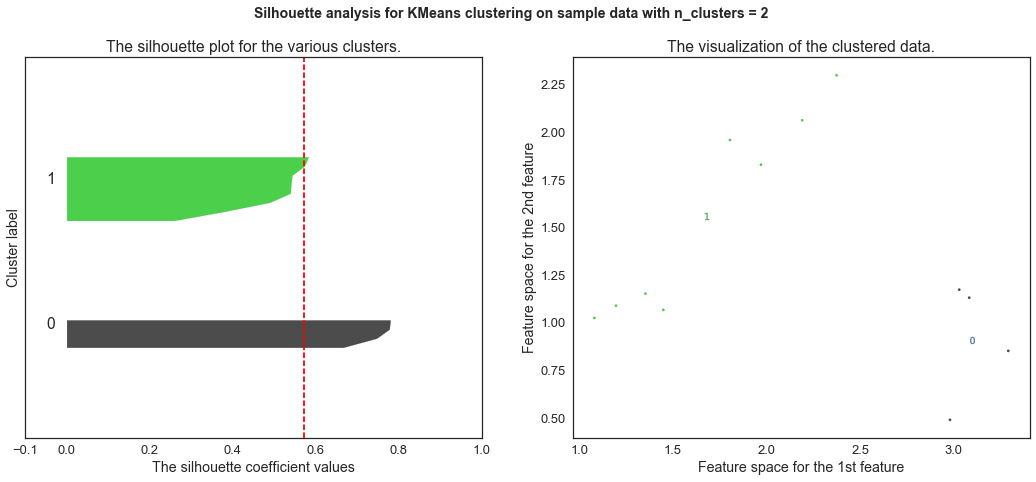

For n_clusters = 3 The average silhouette_score is : 0.731560728069


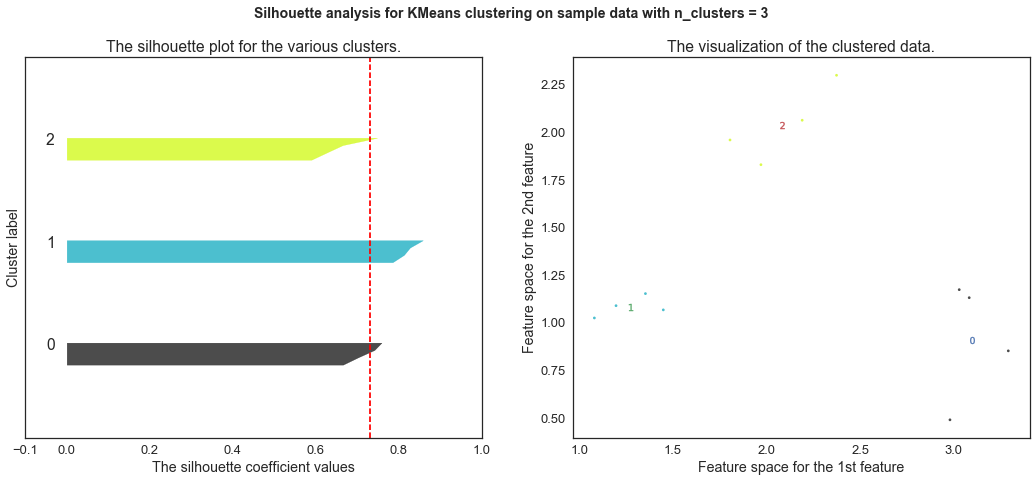

For n_clusters = 4 The average silhouette_score is : 0.617851621162


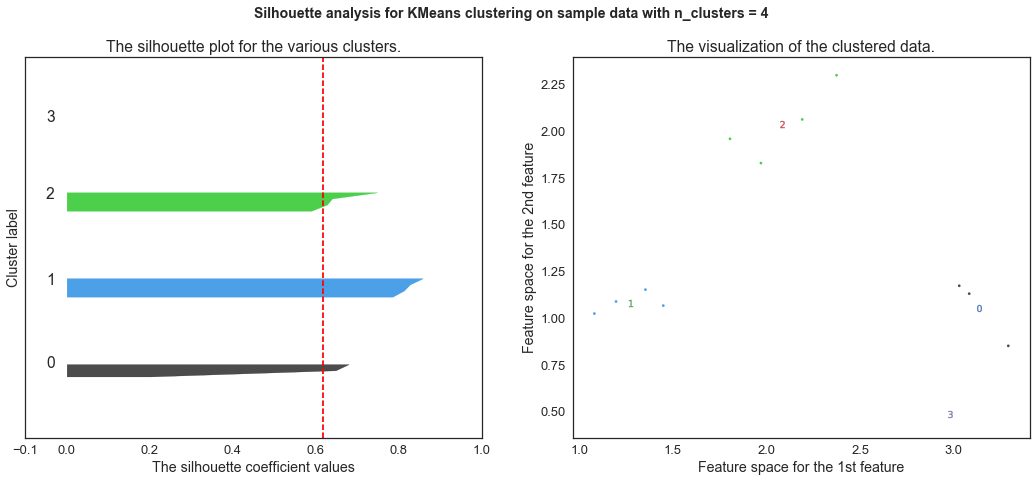

For n_clusters = 5 The average silhouette_score is : 0.542262738509


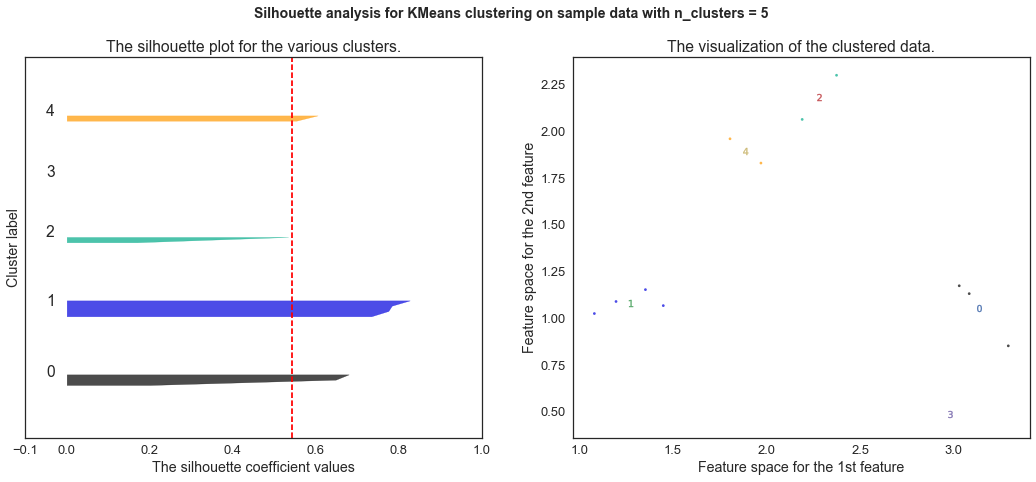

For n_clusters = 6 The average silhouette_score is : 0.551652434358


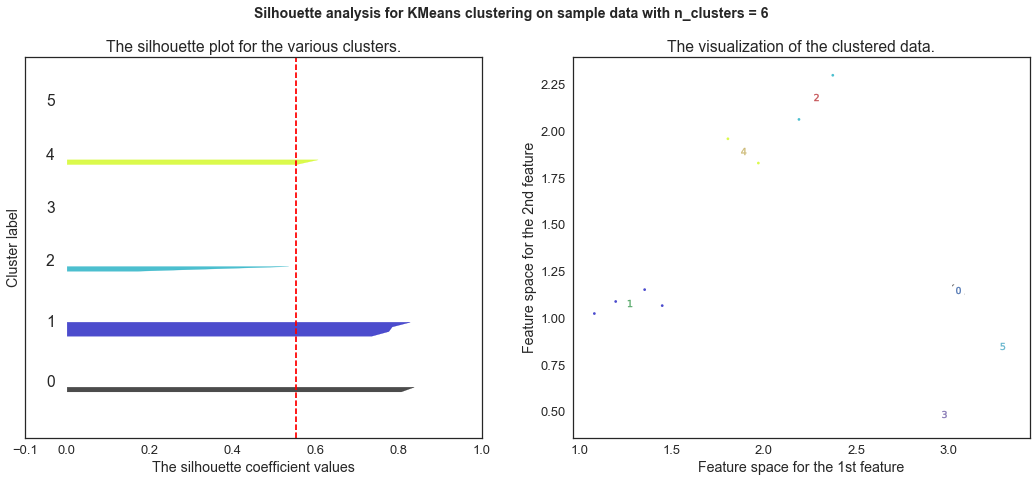

In [56]:
X = df_xy.copy()
plotSilhouette(X)

We can also summarize the average scores in a plot

In [57]:
X = df_xy.copy()  # Using the the dataset of Section 1
K = range(2,11)  # Apply kmeans 2 to 10

# run k-means for each k
KM = [skc.KMeans(n_clusters=k).fit(X) for k in K]

# Note that silhouette_score is unhappy with k=1
# calculate the silhouette for each model
silh_scores = [skm.silhouette_score(X,km.labels_) for km in KM]

# find the best score
kIdx = np.argmax(silh_scores)

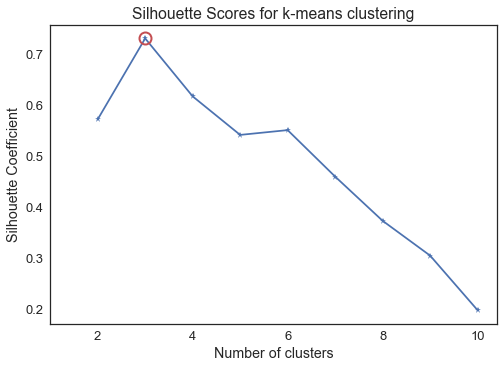

In [58]:
# plot the silhouette scores
plt.plot(K, silh_scores, 'b*-')
plt.plot(K[kIdx], silh_scores[kIdx], marker='o', markersize=12, 
         markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.xlim(1, plt.xlim()[1])
plt.xlabel('Number of clusters');
plt.ylabel('Silhouette Coefficient');
plt.title('Silhouette Scores for k-means clustering');

In the above plot, we pick the number of clusters that gives the __highest silhouette coefficient__, which is k=3, as we desired.

## Exercise
1. Choose two out of the three approaches above, and test them on the iris dataset.

# 4. Evaluating Clusters
Here is a quote from the scikit-learn's [clustering tutorial](http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) regarding clustering performance evaluation.

> Evaluating the performance of a clustering algorithm is not as trivial as counting the number of errors or the precision and recall of a supervised classification algorithm. In particular any evaluation metric should not take the absolute values of the cluster labels into account but rather if this clustering define separations of the data similar to some ground truth set of classes or satisfying some assumption such that members belong to the same class are more similar that members of different classes according to some similarity metric.

We will focus on two situations separately:
1. with ground truth (a given set of classes)
2. without ground truth

Most of the content is borrowed from [scikit-learn's tutorial](http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation). You are encournaged to read the tutorial for more details.

## 4.1 Evaluation with Ground Truth

__The adjusted Rand index__ measures the similarity between two clustering assignments (test vs. groud-truth).
- Permutations are ignored.
- Chance normalization is applied.
- The perfect score is 1.0.
- The worst score is -1.0.

See [here](http://scikit-learn.org/stable/modules/clustering.html#advantages) for its advantages and drawbacks.

Another application of this is to compare the output of two different clustering algorithms. It lets us see how much overlap there is in their predictions.

In [28]:
# The pair below is a perfect match.
labels_true = ['a', 'a', 'a', 'b', 'b', 'b']
labels_predicted = [0, 0, 0, 1, 1, 1]


In [29]:
# Reversing the labels is okay.
labels_predicted2 = [1, 1, 1, 0, 0, 0]


In [30]:
# With a single error.
labels_predicted3 = [1, 0, 1, 0, 0, 0]


In [31]:
# With a lot of errors.
labels_predicted4 = [0, 1, 0, 1, 0, 1]


__Normalized Mutual Information (NMI)__ measures the agreement between two clustering assignments.
- Permutations are ignored.
- A recently proposed version (Adjusted Mutual Information) is normalized against chance.
- Perfect score is 1.0.
- Worst score (or, purely independent assignments) is 0.0.

See [here](http://scikit-learn.org/stable/modules/clustering.html#id10) for its advantages and drawbacks.

In [32]:
# Let's look at the NMI scores of the pairs of assignments defined above.
print("no errors: ",skm.normalized_mutual_info_score(labels_true, labels_predicted))
print("flipped, no errors: ",skm.normalized_mutual_info_score(labels_true, labels_predicted2))
print("one error: ",skm.normalized_mutual_info_score(labels_true, labels_predicted3))
print("many errors: ",skm.normalized_mutual_info_score(labels_true, labels_predicted4))

no errors:  1.0
flipped, no errors:  1.0
one error:  0.479138767492
many errors:  0.0817041659455


There are several more measures (with known ground-truth assignments) that are supported by `scikit-learn`. See [here](http://scikit-learn.org/stable/modules/clustering.html#homogeneity-completeness-and-v-measure).  We'll come back to this when we deal with classification.  It's a similar problem.

See also Manning et al.'s [book chapter](http://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html) for evaluation of clustering.

## 4.2 Evaluation Without Ground Truth

In practice, we do always not have the luxury of ground truths. Where the ground truth is absent, we usually have to evaluate cluster quality by measuring:
1. the degree to which the points in each individual cluster are __similar__ (i.e., cohesiveness or homogeneity of each individual cluster); 
2. the degree to which the points in different clusters are __different__ (i.e., separateness of the clusters).
m
__[Silhouette Coefficient](https://en.wikipedia.org/wiki/Silhouette_(clustering)__ measures the above two aspects simultaneously. It is implemented in `scikit-learn`. 
- Its value is bounded between -1 and 1. 
- A higher score means better clustering. 

See [here](http://scikit-learn.org/stable/modules/clustering.html#id20) for its advantages and drawbacks. 

In [33]:
# Suppose we do not have the true labels for the iris dataset.
# Let us use Silhouette Coefficient to evaluate the result of k-means
# clustering. This time we will use scikit-learn's kmeans implementation.
# Notice we import it as capitalized 'KMeans', to distinguish from scipy's
# kmeans module.
metrics4 = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X = df_iris[metrics4]  # Use all four metrics for the iris dataset


# References
- Coursera Jeff Leek's "Data Analysis" Course Notes: https://github.com/herrfz/dataanalysis
- Scikit-learn clustering tutorial: http://scikit-learn.org/stable/modules/clustering.html
- Manning et al. ["Evaluation of Clustering"](http://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html). _Introduction to Information Retrieval_ (2008).